In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import f1_score
from sklearn.preprocessing import  StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay



In [2]:
train_df = pd.read_csv("../data/train.2024.04.16.csv")

In [3]:
train_df.head()

,Unnamed: 0,Date,Time,Elat,Elon,Dep,Tag,F01,F02,F03,...,F05,F06,F07,F08,F09,F10,F11,F12,F13,y
0,5789,2020-04-21,01:26:21.92,40.748,-111.969,6.3,eq,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,9139,2022-09-10,01:50:17.85,39.426,-110.301,-1.9,mis,NaN,NaN,-0.04,...,-141.5,NaN,12.17,NaN,NaN,NaN,NaN,NaN,0.25,2
2,8625,2022-06-28,06:00:23.98,39.430,-110.301,-1.7,mis,-0.34,NaN,0.32,...,-145.1,NaN,12.54,NaN,NaN,NaN,NaN,NaN,NaN,2
3,6106,2020-05-28,08:24:24.05,38.758,-111.494,6.4,eq,-0.37,NaN,0.34,...,-100.8,NaN,14.15,NaN,NaN,NaN,NaN,NaN,0.05,1
4,978,2014-06-17,16:43:49.18,39.542,-111.718,12.2,eq,NaN,NaN,0.96,...,-96.6,NaN,15.23,NaN,NaN,NaN,NaN,NaN,NaN,1


In [4]:
feature_col_names = ['F01', 'F02', 'F03', 'F04',
       'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13']

In [5]:
train_df

,Unnamed: 0,Date,Time,Elat,Elon,Dep,Tag,F01,F02,F03,...,F05,F06,F07,F08,F09,F10,F11,F12,F13,y
0,5789,2020-04-21,01:26:21.92,40.748,-111.969,6.3,eq,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,9139,2022-09-10,01:50:17.85,39.426,-110.301,-1.9,mis,NaN,NaN,-0.04,...,-141.5,NaN,12.17,NaN,NaN,NaN,NaN,NaN,0.25,2
2,8625,2022-06-28,06:00:23.98,39.430,-110.301,-1.7,mis,-0.34,NaN,0.32,...,-145.1,NaN,12.54,NaN,NaN,NaN,NaN,NaN,NaN,2
3,6106,2020-05-28,08:24:24.05,38.758,-111.494,6.4,eq,-0.37,NaN,0.34,...,-100.8,NaN,14.15,NaN,NaN,NaN,NaN,NaN,0.05,1
4,978,2014-06-17,16:43:49.18,39.542,-111.718,12.2,eq,NaN,NaN,0.96,...,-96.6,NaN,15.23,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7520,6784,2020-12-18,19:38:50.61,37.547,-113.062,5.5,eq,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7521,1267,2015-01-14,20:56:48.63,38.965,-112.912,-2.0,ex,0.26,0.60,0.81,...,-79.5,13.86,12.10,NaN,NaN,NaN,NaN,NaN,NaN,0
7522,2306,2017-03-30,02:33:56.25,39.626,-112.174,-2.0,ex,0.00,0.13,-0.13,...,-114.1,14.09,13.63,0.2,0.36,0.27,0.41,0.13,0.42,0
7523,4555,2020-03-19,13:36:34.83,40.744,-112.035,7.6,eq,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [6]:
all_feats_df = train_df[~np.any(np.isnan(train_df[feature_col_names]), axis=1)]
X = all_feats_df[feature_col_names].to_numpy()
y = all_feats_df["y"].to_numpy()

In [7]:
print(X.shape)
q1, q3  = np.percentile(X, [25, 75], axis=0)
IQR = q3 - q1
lower_fence = q1 - IQR*3.0
upper_fence = q3 + IQR*3.0
drop_inds = np.unique(np.concatenate([np.unique(np.where(X < lower_fence)[0]), 
                                      np.unique(np.where(X > upper_fence)[0])]))
keep_inds = np.delete(np.arange(0, X.shape[0]), drop_inds)
X = X[keep_inds, :]
y = y[keep_inds]
print(X.shape)

(757, 13)
(752, 13)


# Try LDA transform method using all features

In [8]:
# Try scaling
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [9]:
ldaAll = LDA(n_components=2)
ldaAll.fit(X_scaled, y)
y_pred_all = ldaAll.predict(X_scaled)

In [10]:
f1_score(y, y_pred_all, average='macro')

0.944603426956368

In [11]:
X_reduced = ldaAll.transform(X_scaled)

In [12]:
ldaReduced = LDA()
ldaReduced.fit(X_reduced, y)

LinearDiscriminantAnalysis()

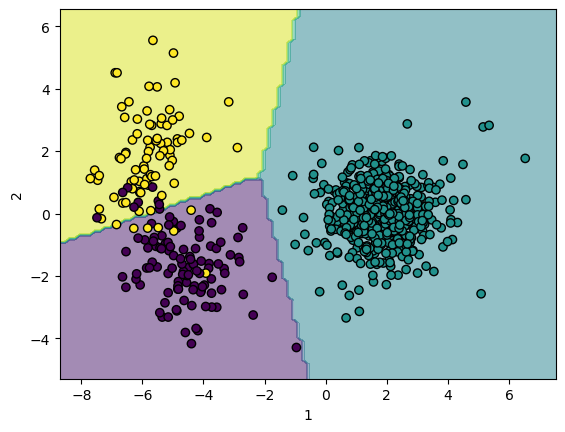

In [13]:
disp = DecisionBoundaryDisplay.from_estimator(
    ldaReduced, X_reduced, response_method="predict",
    xlabel="1", ylabel="2",
    alpha=0.5,
)
disp.ax_.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolor="k")
plt.show()

In [14]:
ldaAll.explained_variance_ratio_

array([0.92638418, 0.07361582])

In [15]:
ldaAll.scalings_

array([[-0.44240607, -0.78814083],
       [ 0.86810741, -0.030358  ],
       [ 0.42754183,  0.689016  ],
       [-0.3929426 , -0.28453929],
       [-0.00253244, -0.16085951],
       [ 0.5471768 ,  0.28884925],
       [ 1.15218423, -0.12512138],
       [ 0.1104229 , -0.29518652],
       [-0.51352749,  1.93197387],
       [-0.13679708, -1.40161924],
       [ 0.13792691, -0.50769946],
       [ 0.0695323 , -0.33675335],
       [-0.82579042,  0.63710954]])

In [16]:
np.argsort(abs(ldaAll.scalings_[:, 0]))+1

array([ 5, 12,  8, 10, 11,  4,  3,  1,  9,  6, 13,  2,  7])

In [17]:
np.argsort(abs(ldaAll.scalings_[:, 1]))+1

array([ 2,  7,  5,  4,  6,  8, 12, 11, 13,  3,  1, 10,  9])

In [18]:
np.sort(abs(ldaAll.scalings_[:, 0]))

array([0.00253244, 0.0695323 , 0.1104229 , 0.13679708, 0.13792691,
       0.3929426 , 0.42754183, 0.44240607, 0.51352749, 0.5471768 ,
       0.82579042, 0.86810741, 1.15218423])

In [19]:
np.sort(abs(ldaAll.scalings_[:, 1]))

array([0.030358  , 0.12512138, 0.16085951, 0.28453929, 0.28884925,
       0.29518652, 0.33675335, 0.50769946, 0.63710954, 0.689016  ,
       0.78814083, 1.40161924, 1.93197387])

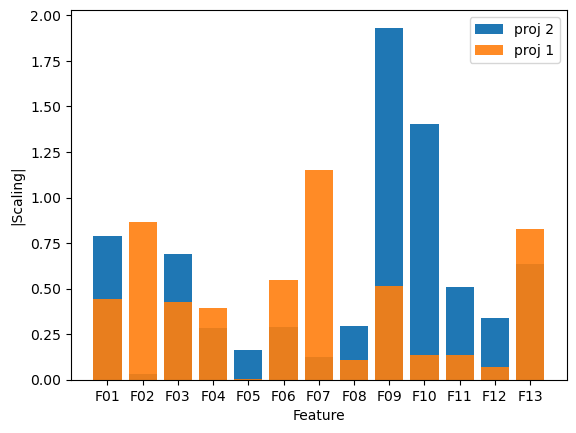

In [20]:
plt.bar(np.arange(0, 13)+1,  abs(ldaAll.scalings_[:, 1]), label="proj 2")
plt.bar(np.arange(0, 13)+1, abs(ldaAll.scalings_[:, 0]), label="proj 1", alpha=0.9)
plt.ylabel("|Scaling|")
plt.xlabel("Feature")
plt.legend()
plt.xticks(np.arange(0, 13)+1, feature_col_names);

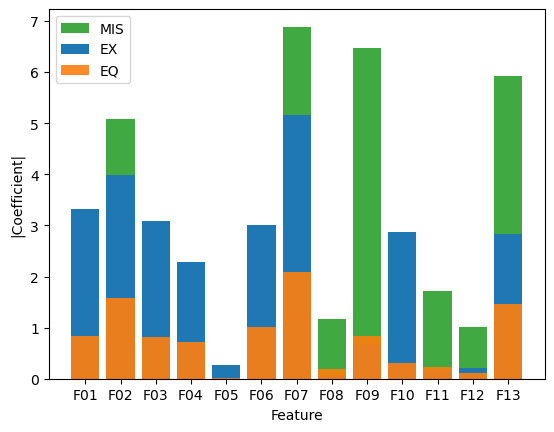

In [21]:
plt.bar(np.arange(0, 13)+1, abs(ldaAll.coef_[2, :]), label="MIS", alpha=0.9, color="C2")
plt.bar(np.arange(0, 13)+1, abs(ldaAll.coef_[0, :]), label="EX", color="C0")
plt.bar(np.arange(0, 13)+1, abs(ldaAll.coef_[1, :]), label="EQ", alpha=0.9, color="C1")
plt.ylabel("|Coefficient|")
plt.xlabel("Feature")
plt.legend()
plt.xticks(np.arange(0, 13)+1, feature_col_names);

In [22]:
def remove_feat_from_scalings(Xvals, scalings, feat_ind):
    plt.figure()
    filt_inds = np.delete(np.arange(scalings.shape[0]), [feat_ind])
    X_filtered = Xvals[:, filt_inds]
    tmp = np.dot(X_filtered, scalings[filt_inds, :])
    raw = np.dot(Xvals, scalings)
    plt.scatter(raw[:, 0], raw[:, 1], color='gray', alpha=0.5)
    plt.scatter(tmp[y==0][:, 0], tmp[y==0][:, 1], label="EX")
    plt.scatter(tmp[y==1][:, 0], tmp[y==1][:, 1], label="EQ")
    plt.scatter(tmp[y==2][:, 0], tmp[y==2][:, 1], label="MIS")
   
    plt.legend()
    plt.title(f"Remove feature {feat_ind+1}")

Text(0.5, 1.0, 'All features')

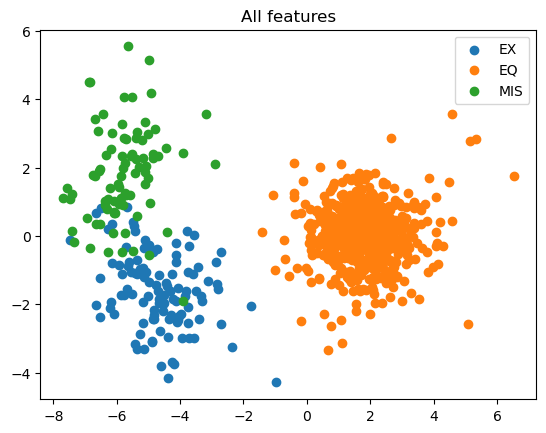

In [23]:
tmp = np.dot(X_scaled, ldaAll.scalings_)
plt.scatter(tmp[y==0][:, 0], tmp[y==0][:, 1], label="EX")
plt.scatter(tmp[y==1][:, 0], tmp[y==1][:, 1], label="EQ")
plt.scatter(tmp[y==2][:, 0], tmp[y==2][:, 1], label="MIS")
plt.legend()
plt.title("All features")

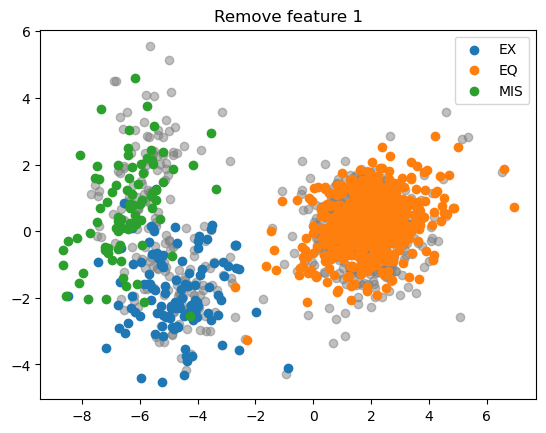

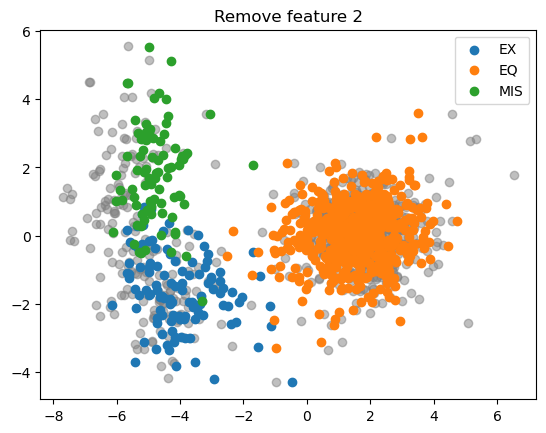

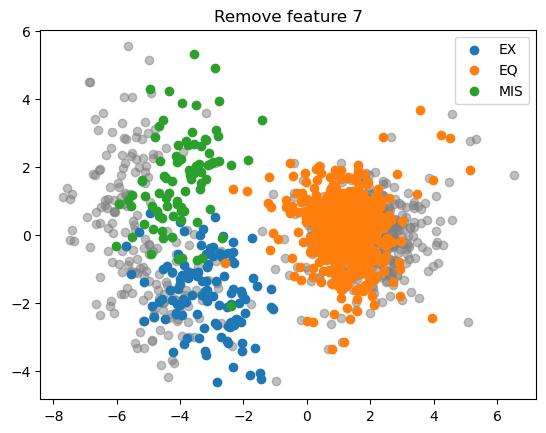

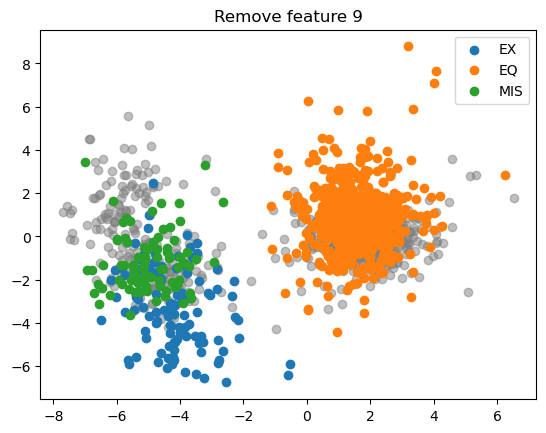

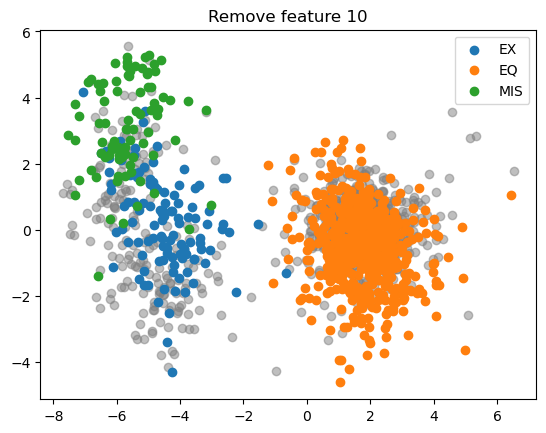

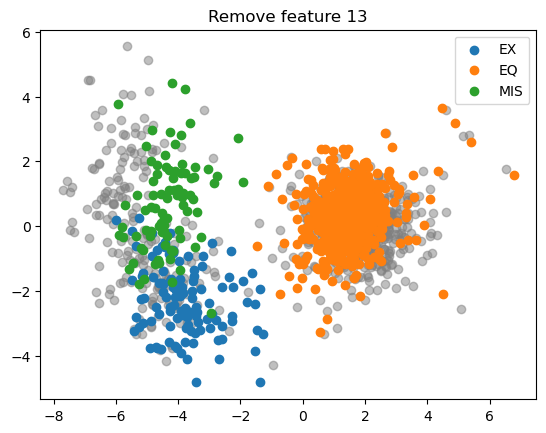

In [24]:
for i in [0, 1, 6, 8, 9, 12]:#range(0, 13):
    remove_feat_from_scalings(X_scaled, ldaAll.scalings_, i)

In [25]:
def plot_hist(Xvals, feat_ind):
    plt.figure()
    bins = np.arange(-3, 3, 0.1)
    plt.hist(Xvals[y==2, feat_ind], bins=bins, color='C2', label="MIS");
    plt.hist(Xvals[y==1, feat_ind], bins=bins, color="C1", label="EQ");
    plt.hist(Xvals[y==0, feat_ind], bins=bins, color="C0", label="EX");
    plt.legend()
    plt.title(f"Feature {feat_ind+1}")

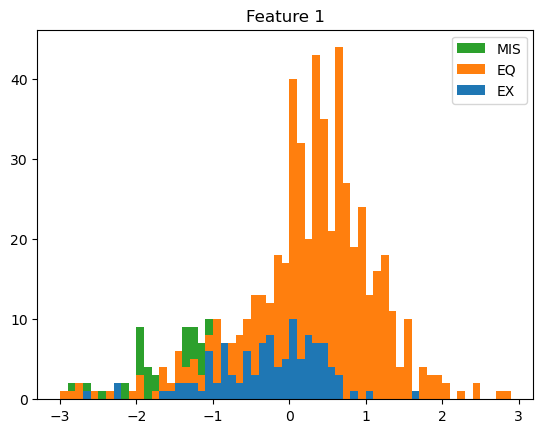

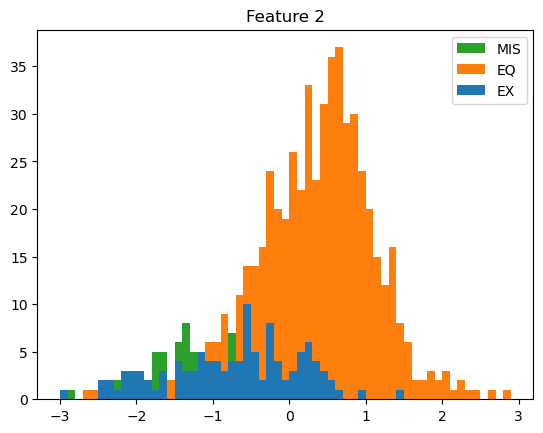

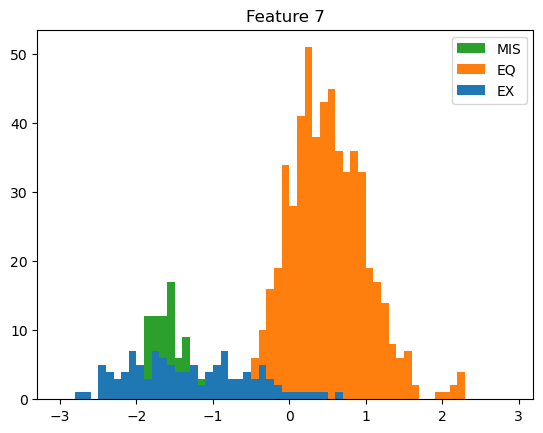

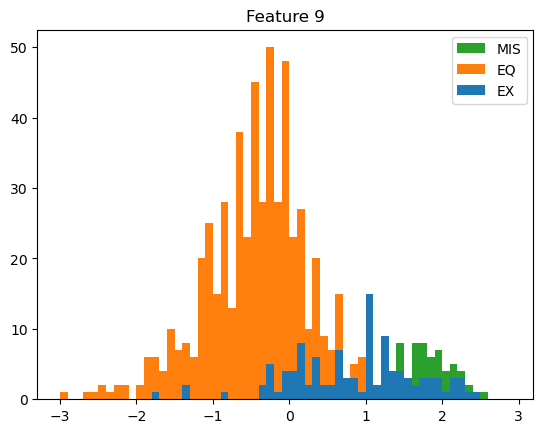

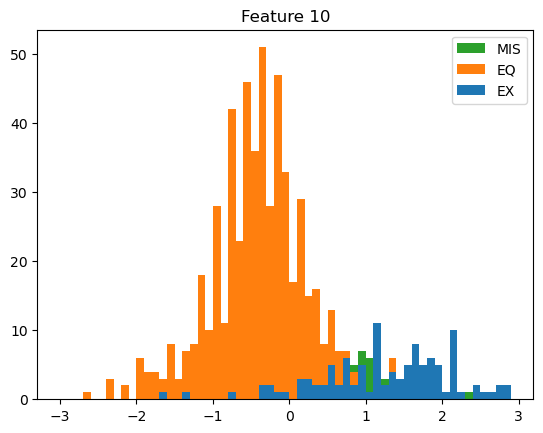

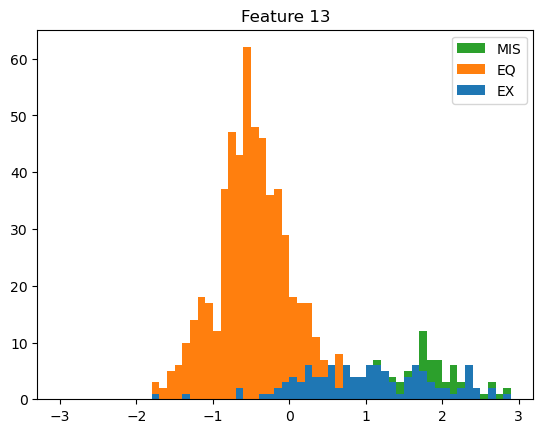

In [26]:
for i in [0, 1, 6, 8, 9, 12]:#range(0, 13):
    plot_hist(X_scaled, i)

In [27]:
def plot_3D(Xvals, feat1, feat2, feat3, view=(20, 350, 0)):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(Xvals[y == 0][:, feat1], Xvals[y==0][:, feat2], Xvals[y==0][:, feat3], label='EX')
    ax.scatter(Xvals[y == 1][:, feat1], Xvals[y==1][:, feat2], Xvals[y==1][:, feat3], label="EQ")
    ax.scatter(Xvals[y == 2][:, feat1], Xvals[y==2][:, feat2], Xvals[y==2][:, feat3], label="MIS")
    ax.view_init(elev=view[0], azim=view[1], roll=view[2])
    ax.set_xlabel(f"F{feat1+1}")
    ax.set_ylabel(f"F{feat2+1}")
    ax.set_zlabel(f"F{feat3+1}")

    ax.legend()
    fig.tight_layout()

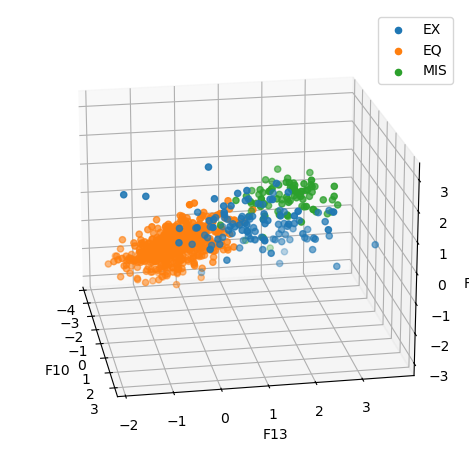

In [28]:
plot_3D(X_scaled, 9, 12, 8)

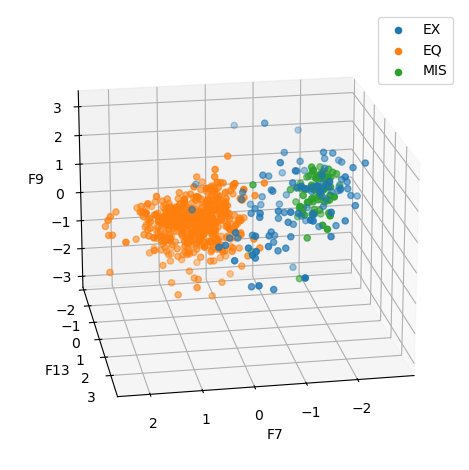

In [29]:
plot_3D(X_scaled, 6, 12, 8, view=(20, 80, 0))

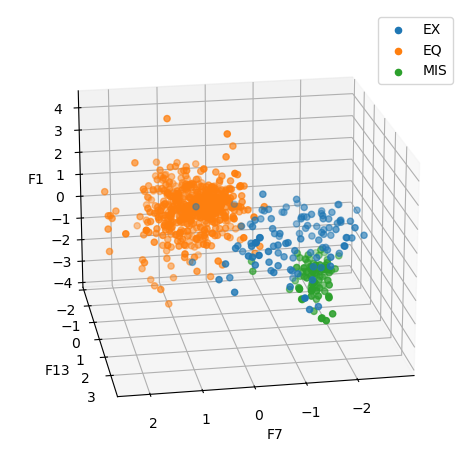

In [30]:
plot_3D(X_scaled, 6, 12, 0, view=(20, 80, 0))

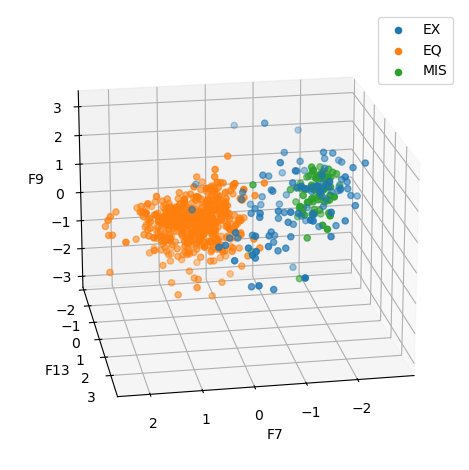

In [31]:
plot_3D(X_scaled, 6, 12, 8, view=(20, 80, 0))

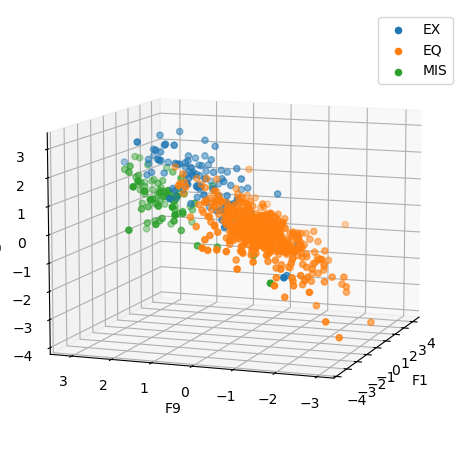

In [32]:
plot_3D(X_scaled, 0, 8, 9, view=(10, 200, 0))

In [33]:
def plot2feats(Xvals, featind1, featind2):
    plt.figure()
    plt.scatter(Xvals[y==0, featind1], X_scaled[y==0, featind2], label="EX")
    plt.scatter(Xvals[y==1, featind1], X_scaled[y==1, featind2], label="EQ")
    plt.scatter(Xvals[y==2, featind1], X_scaled[y==2, featind2], label="MIS")
    plt.xlabel(f"Feature {featind1 + 1}")
    plt.ylabel(f"Feature {featind2 + 1}")
    plt.legend()

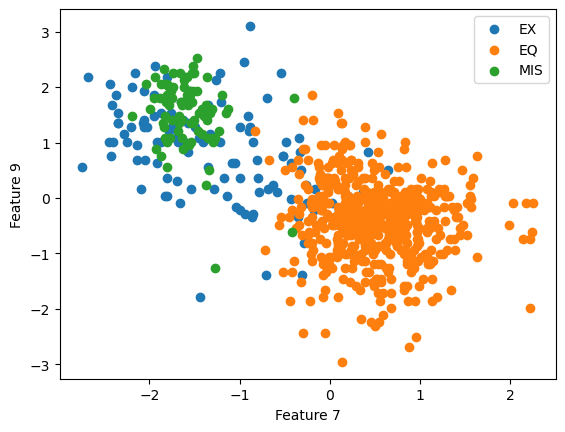

In [34]:
plot2feats(X_scaled, 6, 8)

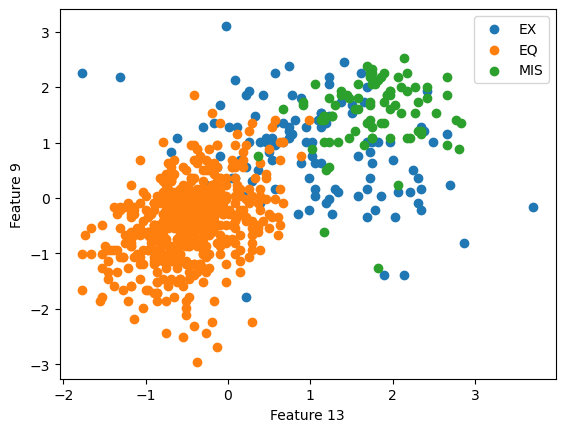

In [35]:
plot2feats(X_scaled, 12, 8)

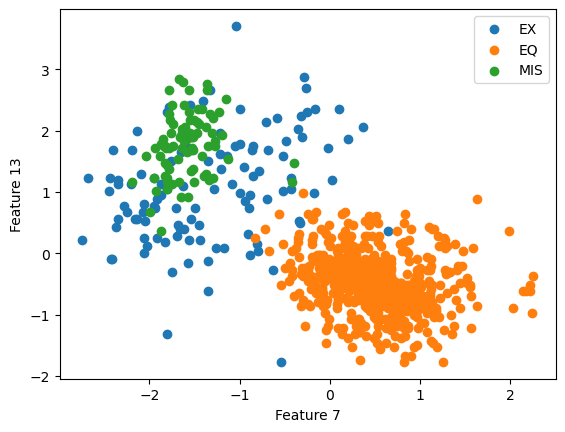

In [36]:
plot2feats(X_scaled, 6, 12)

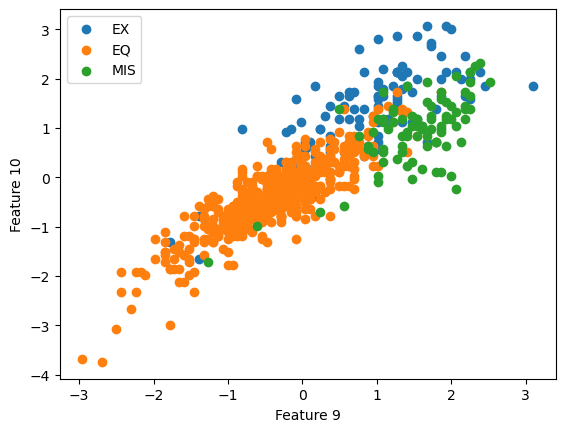

In [37]:
plot2feats(X_scaled, 8, 9)

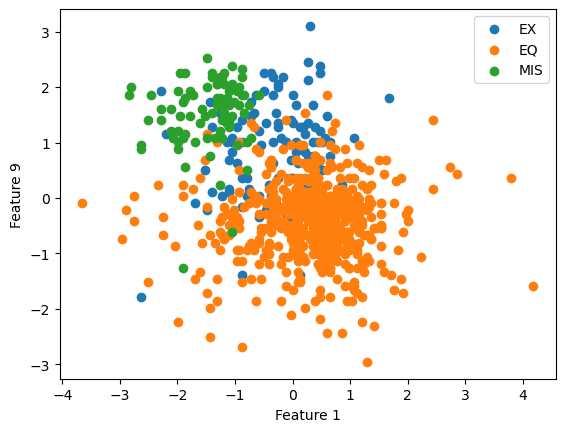

In [38]:
plot2feats(X_scaled, 0, 8)

In [44]:
LDA3feat = LDA()
LDA3feat.fit(X[:, [0, 6, 8, 9, 12]], y)
y_pred3feat = LDA3feat.predict(X[:, [0, 6, 8, 9, 12]])
f1_score(y, y_pred3feat, average="macro")

0.9243849056543089